In [1]:
import os
if os.getcwd().split("/")[-1] != 'BENDR-XAI': os.chdir("../")

import mne
import numpy as np
import matplotlib.pyplot as plt
from utils import *

from matplotlib import animation
import matplotlib.cm as cm
import sys
from tqdm import tqdm

In [2]:
subjects_dir, subject, trans, src_path, bem_path = get_fsaverage()

In [3]:
patient = "S010"

In [4]:
raw_open = get_raw(f'data/eegmmidb/files/{patient}/{patient}R01.edf', filter=True, resample=False)
annotation_open = get_annotations(f'data/eegmmidb/files/{patient}/{patient}R01.edf')
raw_open = get_window_dict(raw_open, annotation_open)['T0'][0]

In [5]:
raw_closed = get_raw(f'data/eegmmidb/files/{patient}/{patient}R02.edf', filter=True, resample=False)
annotation_closed = get_annotations(f'data/eegmmidb/files/{patient}/{patient}R02.edf')
raw_closed = get_window_dict(raw_closed, annotation_closed)['T0'][0]

Effective window size : 1.600 (s)


/home/andersgm/anaconda3/envs/XAI/lib/python3.10/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


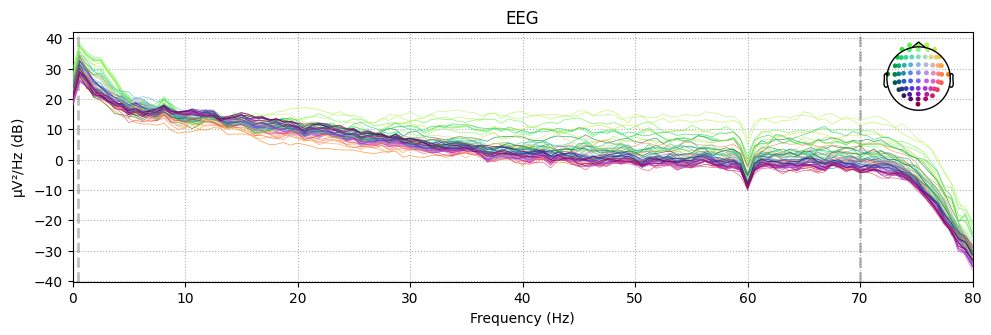

In [6]:
raw_open.compute_psd().plot()
plt.show()

Effective window size : 1.600 (s)


/home/andersgm/anaconda3/envs/XAI/lib/python3.10/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


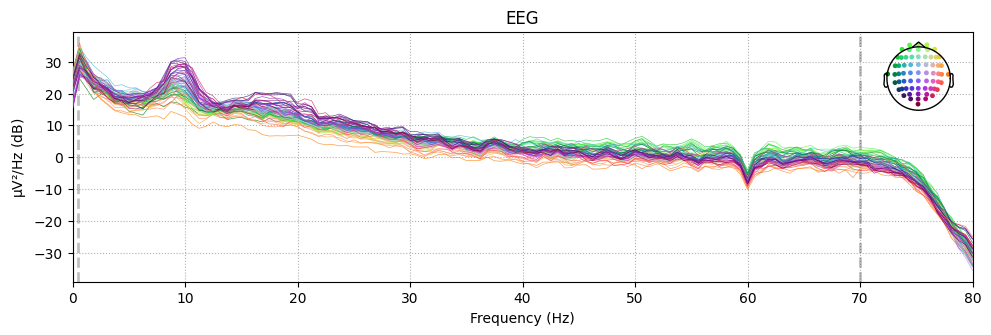

In [7]:
raw_closed.compute_psd().plot()
plt.show()

In [8]:
random_edf_file_path = 'notebooks/S001R03.edf' 
mmidb_path = Path(r"/home/s194260/BENDR-XAI/data/eegmmidb/files")
parcellation_name = "aparc.a2009s"
snr = 1.0

info = get_raw(random_edf_file_path, filter=True).info # Just need one raw to get info
src = get_src(src_path)
fwd = get_fwd(info, trans, src_path, bem_path)

labels = get_labels(subjects_dir, parcellation_name = parcellation_name)

In [9]:
cov = get_cov(raw_open)
compute_inverse = make_fast_inverse_operator(raw_open.info, fwd, cov, snr=snr)

In [10]:
verbose = True
method = "eLORETA"
nave = 1
lambda2 = 1/snr**2
inv = mne.minimum_norm.make_inverse_operator(info, fwd, cov, verbose=verbose)
inv = mne.minimum_norm.prepare_inverse_operator(inv, nave, lambda2, method=method, verbose=verbose)

Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 64 channels.
    64 out of 64 channels remain after picking
Selected 64 channels
Creating the depth weighting matrix...
    64 EEG channels
    limit = 20485/20484 = 2.174517
    scale = 125525 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 8.1e-12 (2.2e-16 eps * 64 dim * 5.7e+02  max singular value)
    Estimated rank (eeg): 63
    EEG: rank 63 computed from 64 data channels with 1 projector
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD

In [11]:
stc = mne.minimum_norm.apply_inverse_raw(raw_open, inv, lambda2, method=method, nave=nave, prepared=True, verbose=verbose,
                                   start=0, stop=160*5)

Applying inverse to raw...
    Picked 64 channels from the data
    Computing inverse...
    Eigenleads already weighted ... 
    combining the current components...
[done]


In [12]:
vertices = get_vertices(src)
tris_vertices = get_vertices_tris(src)

sources = get_sources(src)
tris_sources = get_sources_tris(src)

In [13]:
color = np.mean(stc.data, axis=1)
# Standardize color between 0 and 1
color = (color - np.min(color)) / (np.max(color) - np.min(color))
color = color.reshape(2, 10242)

In [32]:
%matplotlib inline
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1, projection='3d')

lh_mesh = ax.plot_trisurf(*sources[0].T, triangles=tris_sources[0], linewidth=0.1, shade=False,
                        antialiased=True, edgecolor=(0,0,0,0.5), cmap="hot")

lh_mesh.set_array(color[0])
#fig.colorbar(lh_mesh, shrink=0.5)

rh_mesh = ax.plot_trisurf(*sources[1].T, triangles=tris_sources[1], linewidth=0.1, shade=False,
                        antialiased=True, edgecolor=(0,0,0,0.5), cmap="hot")

rh_mesh.set_array(color[1])
fig.colorbar(rh_mesh, shrink=0.5)

ax.set_xlim(-0.06, 0.06)
ax.set_ylim(-0.08, 0.04)
ax.set_zlim(-0.04, 0.09)
ax.set_box_aspect([1,1,1])
ax.view_init(90, -90)
ax.axis("off")
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.tight_layout()
plt.show()

: 

: 